DAT405 Assignment 4

Noah Lanai - 9808252192 - 12h work

Carl Hjalmarsson - 9305198930 - 12h work

In [19]:
# Importing libraries
import nbdime
import pandas as pd
import tarfile
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Problem **1 a)** and **b)**

In [20]:
# Extract files and convert to a dataframe. Label "ham" and "spam" for readability
def extract_files(files, m_class):  
    rows = []
    for fname in files:
        tfile = tarfile.open(fname, 'r:bz2')
        for member in tfile.getmembers():
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row.decode('latin-1'), 'class': m_class})
        tfile.close()
    return pd.DataFrame(rows)

# Get data for different class of email
ham_df = extract_files(['./20021010_easy_ham.tar.bz2', './20021010_hard_ham.tar.bz2'], 'ham')
easyham_df = extract_files(['./20021010_easy_ham.tar.bz2'], 'ham')
hardham_df = extract_files(['./20021010_hard_ham.tar.bz2'], 'ham')
spam_df = extract_files(['./20021010_spam.tar.bz2'], 'spam')

def preprocess(ham_df, spam_df):
    # Split up data into train and test
    hamtrain, hamtest = train_test_split(ham_df, test_size = 0.25, random_state = 0)
    spamtrain, spamtest = train_test_split(spam_df, test_size = 0.25, random_state = 0)

    # Merge data to one big set
    train_data = pd.concat([hamtrain, spamtrain])
    test_data = pd.concat([hamtest, spamtest])

    # Replacing classes with binary numbers
    to_replace = {'ham': 0, 'spam': 1}
    train_data.replace(to_replace, inplace=True)
    test_data.replace(to_replace, inplace=True)
    train_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)

    return train_data, test_data

### Problem **2 a)** and **b)**

Accuracy score for the Multinomial naive Bayes classifier:
 0.9794437726723095


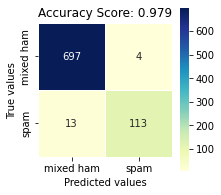

True poitive rate: 0.8968253968253969, true negative rate: 0.9942938659058488

Accuracy score for the Bernoulli naive Bayes classifier:
 0.8875453446191052


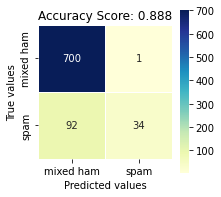

True poitive rate: 0.2698412698412698, true negative rate: 0.9985734664764622



In [17]:
def classify_data(classifier, train_data, test_data):

    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data['message']).toarray()
    y_train = train_data['class']
    X_test = vectorizer.transform(test_data['message']).toarray()
    y_test = test_data['class']

    # Run multinomial or Bernoulli naive Bayes classifiers
    # Laplace smoothing, alpha=1
    classifier.fit(X_train, y_train)
    predict = classifier.predict(X_test)

    return y_test, predict

def generate_results(labels, predictions, classifier_name, hamtype):
    if classifier_name == "mnb":
        string = "Multinomial naive Bayes classifier"
    elif classifier_name == "bernb":
        string = "Bernoulli naive Bayes classifier"
    
    print("Accuracy score for the {}:\n".format(string), metrics.accuracy_score(labels, predictions))

    # Confusion matrix
    cm = metrics.confusion_matrix(labels, predictions)
    xAxisLabels = ('{}'.format(hamtype), 'spam')
    yAxisLabels = ('{}'.format(hamtype), 'spam')
    plt.figure(figsize = (3,3))
    sns.heatmap(cm, annot = True, fmt = "d", linewidths=.5, square=True, xticklabels=xAxisLabels, yticklabels=yAxisLabels, cmap="YlGnBu")
    plt.xlabel("Predicted values")
    plt.ylabel("True values")
    allSampleTitle = 'Accuracy Score: %.3f' % metrics.accuracy_score(labels, predictions)
    plt.title(allSampleTitle, size = 12)
    plt.show()

    # Calculate TPR and TNR
    TN, FN, TP, FP = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
    TPR, TNR = TP/(TP+FN), TN/(TN+FP)
    print("True positive rate: {}, true negative rate: {}\n".format(TPR, TNR))

#Run classifier on easy and hard ham mixed, multinomial naive Bayes
train_data, test_data = preprocess(ham_df, spam_df)
mnb = MultinomialNB(alpha = 1)
mnb_labels, mnb_predict = classify_data(mnb, train_data, test_data)
generate_results(mnb_labels, mnb_predict, "mnb", "mixed ham")

#Run classifier on easy and hard ham mixed, multinomial naive Bayes
bernb = BernoulliNB(binarize = 0)
bernb_labels, bernb_predict = classify_data(bernb, train_data, test_data)
generate_results(bernb_labels, bernb_predict, "bernb", "mixed ham")


#### **Differences between models**
The multinomial naive Bayes model implements the naive Bayes algorithm for multinomially distributed data, which is a generalisation of the binomial distribution. For n number of trials it calculates the probability of **x_k** number of successes for **k** different features, i.e. the probability of finding **k** different words in the same text **x_k** number of times. The algorithm calculates the maximum likelihood of a specific word occuring given a specified class, to be used in the naive Bayes formula, based on word count vectors. If a word does not occur it is ignored in the calculation of the maximum likelihood.

The Bernoulli naive Bayes model implements the naive Bayes algorithm for multivariate Bernoulli distributed data, which means that each feature has to be condensed to a binary value, which is done using the binarize parameter to provide a threshold for feature count. This gives binary-valued feature vectors, meaning that the word counts for each individual word is condensed to either 1 or 0 depending on the threshold. The algorithm calculates the likelihood of a specific word occuring, to be used in the naive Bayes formula, based on these binary-valued feature vectors. This version of calculating the maximum likelihood also penalizes non-occurrence of a word.

The main differences are the distributions used to calculate the probability terms of the naive Bayes formula. Adding to this, the main difference seems to be in how it calculates the likelihood terms, and what inputs to use for this calculation; the feature vectors.

#### **Choice of binarize**
The Bernoulli model seemed to fare worse when increasing the binarize variable from the default value of 0, which is why we decided to keep the default value.

#### Differences in performance
Referring to the scikit-learn.org page, it states that the Bernoulli naive Bayes model might perform better on some datasets, especially those with shorter documents. We found this not to be the case when comparing since email messages are usually quite short in comparison to other texts. When discarding the word counts we lose information. If we for example set the binary parameter to two, then every word that occurs once will be set to zero. These words will not be included in the classification which might impact the result. For example if the word "invest" occurs one time in an email. This will not necessarily increase the probability of spam.

### 3 **i. and ii.**

Accuracy score for the Multinomial naive Bayes classifier:
 0.9803664921465969


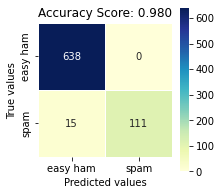

True poitive rate: 0.8809523809523809, true negative rate: 1.0

Accuracy score for the Bernoulli naive Bayes classifier:
 0.9109947643979057


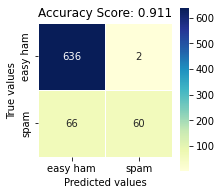

True poitive rate: 0.47619047619047616, true negative rate: 0.9968652037617555

Accuracy score for the Multinomial naive Bayes classifier:
 0.9259259259259259


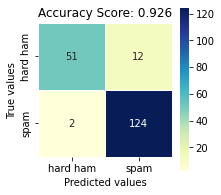

True poitive rate: 0.9841269841269841, true negative rate: 0.8095238095238095

Accuracy score for the Bernoulli naive Bayes classifier:
 0.8571428571428571


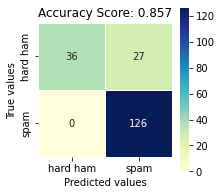

True poitive rate: 1.0, true negative rate: 0.5714285714285714



In [18]:
#Run classifier on easy ham, multinomial naive Bayes
train_data, test_data = preprocess(easyham_df, spam_df)
mnb = MultinomialNB(alpha=1)
mnb_labels, mnb_predict = classify_data(mnb, train_data, test_data)
generate_results(mnb_labels, mnb_predict, "mnb", "easy ham")

#Run classifier on easy ham mixed, multinomial naive Bayes
bernb = BernoulliNB(binarize=0)
bernb_labels, bernb_predict = classify_data(bernb, train_data, test_data)
generate_results(bernb_labels, bernb_predict, "bernb", "easy ham")

#Run classifier on hard ham, multinomial naive Bayes
train_data, test_data = preprocess(hardham_df, spam_df)
mnb = MultinomialNB(alpha = 1)
mnb_labels, mnb_predict = classify_data(mnb, train_data, test_data)
generate_results(mnb_labels, mnb_predict, "mnb", "hard ham")

#Run classifier on hard ham mixed, multinomial naive Bayes
bernb = BernoulliNB(binarize = 0)
bernb_labels, bernb_predict = classify_data(bernb, train_data, test_data)
generate_results(bernb_labels, bernb_predict, "bernb", "hard ham")

#### Differences in performance
The best accuracy score was for the naive Bayes classifier for eazy ham. The data set was predicted with over 99% accuracy. Eazy ham had the best score for both the methods. The lowest accuracy score where the Bernoulli naive Bayes classifier for the hard ham data set. The conclution is that the best method to use is the multinomial naive Bayes classifier, since it performs best for both data sets, and that eazy ham is easier for the computer to predict.

When looking at the confusion matrices we can see a clear difference between classifying easy ham and hard ham emails. The easy ham has a good true negative rate for both the Multidimensional naive Bayes method and the Bernoulli naive Bayes method. For the hard ham case, it is the opposite. The hard ham has a good true positive rate for both the methods but a less good score on the true negative rate. This means that some of the spam emails are being classified as easy ham emails and that some of the hard ham emails are being classified as spam. We can also see that the Multidimensional naive Bayes model gives an overall better classification for both easy ham and hard ham, since the true positive rate and true negative does not differentiate as much as when using the Bernoulli naive Bayes method. However, the Bernoulli naive Bayes classifier gets perfect scores (1.0) on the true negative rate for the easy ham data set and on the hard ham data set, but it also scores the worst at the other rate for both datasets.